# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.500339,True,2.903505
1,-0.304842,True,6.162715
2,0.102473,True,5.459168
3,-1.129590,False,-0.132882
4,1.059201,True,4.721072
...,...,...,...
995,-1.864654,False,-0.248634
996,-1.023875,False,-1.308329
997,0.605013,True,4.823555
998,-0.723034,False,-2.239869


<Axes: xlabel='v0'>

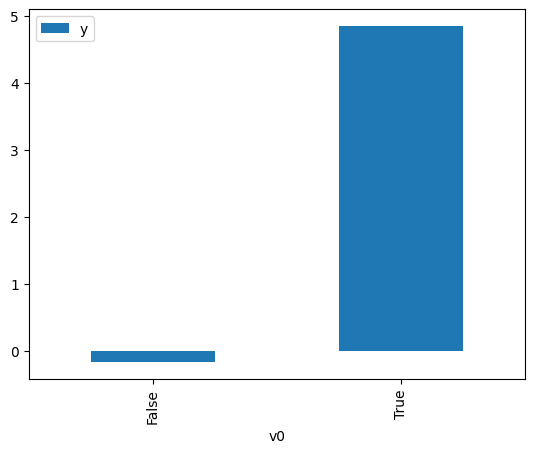

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

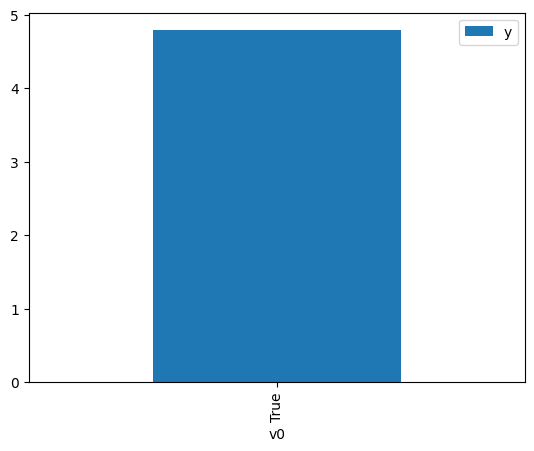

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.750992,False,-1.142673,0.868059,1.151995
1,-1.295465,False,-2.194910,0.962297,1.039180
2,0.953148,False,-0.746902,0.086334,11.582975
3,-0.299072,False,-0.768213,0.681064,1.468291
4,-1.484340,False,-3.162106,0.976104,1.024481
...,...,...,...,...,...
995,-0.086928,False,0.115637,0.557358,1.794178
996,-0.378302,False,-0.535993,0.722308,1.384450
997,0.029768,False,0.791588,0.484975,2.061960
998,1.013528,False,1.770703,0.075189,13.299849


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.039523,True,2.838157,0.006107,163.752143
1,1.421717,True,7.390177,0.971417,1.029424
2,0.637632,True,6.182872,0.828302,1.207289
3,0.558829,True,6.019191,0.798578,1.252226
4,-1.698136,True,5.534872,0.014172,70.561023
...,...,...,...,...,...
995,-0.109129,True,4.920626,0.429050,2.330729
996,-0.660860,True,4.663798,0.159831,6.256599
997,0.080484,True,5.795826,0.546464,1.829948
998,1.323046,True,4.512367,0.963745,1.037619


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                              6856.
Date:                Thu, 27 Jul 2023   Prob (F-statistic):                        0.00
Time:                        09:05:54   Log-Likelihood:                         -1438.8
No. Observations:                1000   AIC:                                      2882.
Df Residuals:                     998   BIC:                                      2891.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3133      0.037      8.533      0.000       0.241       0.385
x2             5.0655      0.052     97.847      0.000       4.964       5.167
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.506
Skew:                           0.042   Prob(JB):                        0.777
Kurtosis:                       2.929   Cond. No.                         1.90
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""